In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# seller_name = ["seller_id", "breed", "good_id", "good_stock",
#                "depot_id", "brand", "place", "year", "level", "category"]
# buyer_name = ["buyer_id", "hold_time", "buy_count", "breed", "expect1", "value1",
#               "expect2", "value2", "expect3", "value3", "expect4", "value4", "expect5", "value5"]

df_seller = pd.read_csv("./seller.txt", header=0, low_memory=False, dtype=np.str)
df_buyer = pd.read_csv("./buyer.txt", header=0, low_memory=False, dtype=np.str)
# df_seller.fillna(value='null', inplace=True)
# df_buyer.fillna(value='null', inplace=True)
df_seller[['货物数量（张）']] = df_seller[['货物数量（张）']].values.astype(int)
df_buyer[['平均持仓时间', '购买货物数量']] = df_buyer[['平均持仓时间', '购买货物数量']].values.astype(int)

In [2]:
df_seller.head()

,卖方客户,品种,货物编号,货物数量（张）,仓库,品牌,产地,年度,等级,类别
0,999900000001,CF,CF2020011104087,8,314,NaN,新疆,2020,1230A,S1U2P3
1,999900000001,CF,CF2020011103822,1,335,NaN,新疆,2020,1228C,S2U3P2
2,999900000002,CF,CF2020011108737,2,309,NaN,非新疆,2020,2228A,S2U3P2
3,999900000002,CF,CF2020011101610,6,325,NaN,新疆,2020,4128C,S3U2P3
4,999900000002,CF,CF2020011104593,2,332,NaN,新疆,2020,4128C,S1U3P2


In [3]:
df_buyer.head()

,买方客户,平均持仓时间,购买货物数量,品种,第一意向,值,第二意向,值.1,第三意向,值.2,第四意向,值.3,第五意向,值.4
0,999800000000,3390,40,CF,仓库,314,产地,新疆,等级,4131B,类别,S3U3P3,NaN,NaN
1,999800000001,4952,5,CF,仓库,325,年度,2020,产地,新疆,类别,S3U4P2,等级,1130A
2,999800000002,3711,24,CF,仓库,301,产地,新疆,等级,4128A,类别,S3U3P3,年度,1920
3,999800000003,4100,56,CF,仓库,304,年度,1920,产地,新疆,类别,S3U3P2,NaN,NaN
4,999800000004,237,57,CF,仓库,301,类别,S2U3P2,产地,新疆,等级,2128C,年度,1920


In [4]:
df_seller_gr = df_seller.groupby(["品种", "仓库"]).agg({'货物数量（张）': {'sum', 'count'}})
print("shape: ", df_seller_gr.shape)
df_seller_gr

shape:  (43, 2)


货物数量（张）       
           sum  count
品种 仓库                
CF 301   63695  12722
   302   67286  13529
   303   65267  13084
   304   62612  12539
   305   62392  12507
   306   64718  12924
   307   63653  12688
   308   66946  13413
   309   69366  13833
   310   66874  13304
   311   72762  14528
   313   62323  12417
   314   67194  13490
   317   66246  13341
   319   72480  14472
   320   72752  14502
   322   62418  12465
   323   71786  14378
   324   66979  13381
   325   67030  13366
   326   70873  14152
   327   61125  12205
   328   68153  13527
   329   63032  12706
   330   70223  13955
   331   64605  12979
   332   66425  13390
   333   68603  13650
   334   61844  12381
   335   70338  14009
SR 112  241155   2412
   409  235380   2323
   417  235411   2358
   428  220534   2194
   435  231887   2304
   437  249409   2452
   438  234793   2346
   441  229903   2293
   445  212022   2098
   449  222794   2210
   450  218586   2218
   452  237874   2378
   508  230252   2256

<Figure size 7200x7200 with 0 Axes>

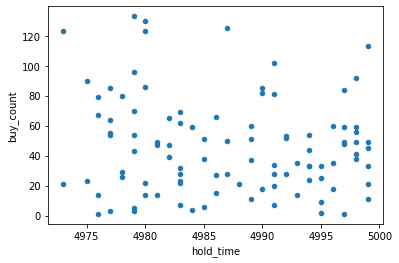

In [5]:
df_buyer_gr = df_buyer.groupby(["品种", "第一意向", "值"])

for it in df_buyer_gr:
    df = it[1]
    df = df.sort_values(by='平均持仓时间', ascending=False)
    data = df[["平均持仓时间", "购买货物数量"]].head(100)
    data = data.rename(columns={'平均持仓时间': 'hold_time', '购买货物数量': 'buy_count'})
    
    plt.figure(figsize=(100, 100))
    data.plot(x="hold_time", y="buy_count", kind="scatter")
    plt.show()
    
    break


In [33]:
df_buyer_gr = df_buyer.groupby(["品种", "第一意向", "值"]).agg({'购买货物数量': {'sum', 'count'}})
df_buyer_gr.columns.get_level_values(1)
df_buyer_gr.columns = df_buyer_gr.columns.droplevel(0)
df_buyer_gr.head(10)

sum  count
品种 第一意向 值                 
CF 产地   新疆   728055  18045
        非新疆   64241   1619
   仓库   301  103041   2544
        302    9407    264
        303   10147    251
        304  106326   2679
        306    9141    226
        307    9010    234
        308    8265    204
        309    9581    237